In [1]:
import importlib, os, gc, sys
import SXBQ as sx

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact


from scipy.signal import find_peaks
from scipy.stats import linregress


from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.7)

import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

In [3]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()

dS, dT=0.1,0.05

c_isopyc='#558C8C'
c_diapy='#963D5A'

# Import files

In [ ]:
glider_trans=xr.open_dataset('../data/WMT_sg079_2dt_0.1_0.05.nc')
glider_trans['G_si']=glider_trans.G_si.where(glider_trans.G_si!=0, np.nan)
glider_trans['G_ti']=glider_trans.G_ti.where(glider_trans.G_ti!=0, np.nan)
    
argo_trans=xr.open_dataset('../data/Argo_bymonth_WMT_01_0.05.nc')
argo_transMEAN=xr.open_dataset('../data/ArgoAPRILJULY_WMT_01_0.05.nc').isel(time_mid=0)

In [5]:
ds_79=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_pp_pressure.nc')

ds2_=xr.open_dataset('../data/sea079_by_transect.nc')

In [6]:
ds_79_DAC= xr.open_dataset('/home/jupyter-estelfont/common/fridge/2015_16_OMAN/SG579_timeseries.nc')
ds_79['DAC_u']=('profile_number', ds_79_DAC.DAC_u.rename({'dives':'dive_num'}).interp(dive_num=ds_79.dive_num.mean('pressure').round().values).values)
ds_79['DAC_v']=('profile_number', ds_79_DAC.DAC_v.rename({'dives':'dive_num'}).interp(dive_num=ds_79.dive_num.mean('pressure').round().values).values)

ds_79['t']=('profile_number', pd.to_datetime(ds_79.time.mean('pressure').values))

ds_79['lon_pp']=('profile_number', ds_79.longitude.mean('pressure').values)
ds_79['lat_pp']=('profile_number', ds_79.latitude.mean('pressure').values)
ds_79=ds_79.swap_dims({'profile_number':'t'}).sortby('t')
ds_79=ds_79.isel(t=slice(0,int(np.nanmax(ds_79.profile_number)-1)))

In [7]:
def data_grid_roll(month, var): # month is Trans num, cons_temp, abs_salinity ,  potential_density , spice

    get_section1=ds2_.sel(transect_number=month).where(ds2_.sel(transect_number=month).cons_temp.count('pressure')!=0, drop=True)
    # get_section1['time_pp']=get_section1.time.mean('pressure')
    def roll(ds):
        # ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(5,axis=1, center=True).mean()
        ds = pd.DataFrame(ds).interpolate(limit=2,axis=0).rolling(3,axis=0, center=True).mean()
        
        return ds.to_numpy()
    dx=2
    xaxis=np.arange(0,80+dx,dx)
    ct1=get_section1.groupby_bins('distance_bin_on_transect', bins=xaxis).mean()[var].values
    if var=='time':
        ct1=np.nanmean(ct1, axis=1)
    
    return roll(ct1)[:, 0]#[:, int(10/dx):int(-7/dx)]

DAC_u_=[data_grid_roll(i, 'DAC_u') for i in range(1, 25)]
DAC_v_=[data_grid_roll(i, 'DAC_v') for i in range(1, 25)]

time_=[data_grid_roll(i, 'time') for i in range(1, 25)]

DAC_u_prime=DAC_u_-np.nanmean(DAC_u_, axis=0)
DAC_v_prime=DAC_v_-np.nanmean(DAC_v_, axis=0)


ds_79_pp_sigma=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_pp_sigma.nc')

ds_79_pp_sigma['lon_pp']=('profile_number', ds_79_pp_sigma.longitude.mean('potential_density').values)
ds_79_pp_sigma['lat_pp']=('profile_number', ds_79_pp_sigma.latitude.mean('potential_density').values)
ds_79_pp_sigma=ds_79_pp_sigma.swap_dims({'profile_number':'t'}).sortby('t')
ds_79_pp_sigma=ds_79_pp_sigma.isel(t=slice(0,int(np.nanmax(ds_79_pp_sigma.profile_number)-1)))

ds_79_pp_sigma['t']=('t', pd.to_datetime(ds_79.time.mean('pressure').values))



df_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2023_n30.0_s-5.0_w30.0_e80.0.nc')
df_bath=df_bath.where(df_bath.lat>20, drop=True).where(df_bath.lon<63, drop=True).where(df_bath.lon>55, drop=True).where(df_bath.lat<28, drop=True)

ds_ssh_15_16=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1746806780071.nc')
times_=[ds_ssh_15_16.sel(time='2015-03-15').adt.time.values,ds_ssh_15_16.sel(time='2015-04-01').adt.time.values,  ds_ssh_15_16.sel(time='2015-04-15').adt.time.values, ds_ssh_15_16.sel(time='2015-05-01').adt.time.values, ds_ssh_15_16.sel(time='2015-05-15').adt.time.values, ds_ssh_15_16.sel(time='2015-06-01').adt.time.values]

### EKE & eddy detection

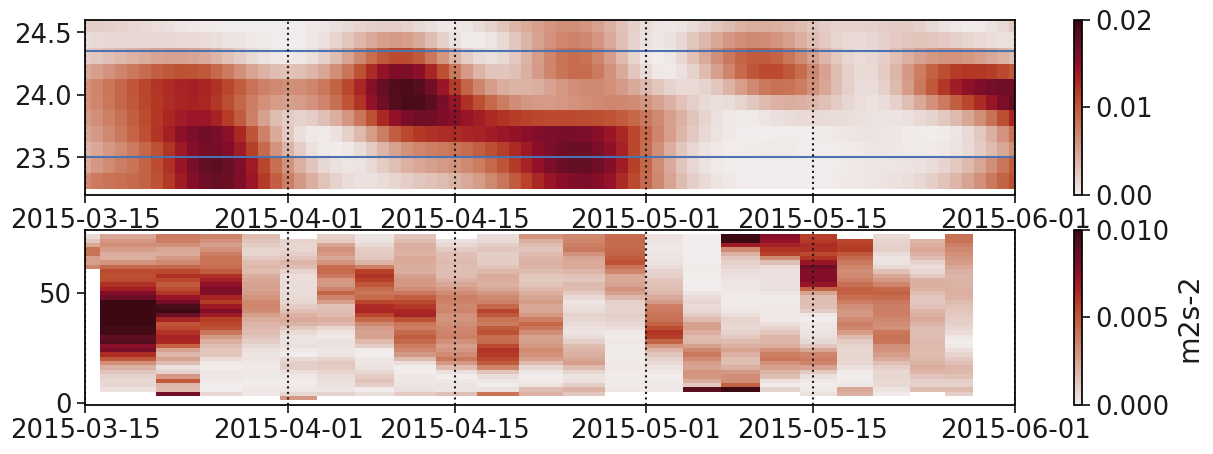

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(211)
uprime=(ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).sel(longitude=slice(58.6,59)).ugos-ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).sel(longitude=slice(58.6,59)).ugos.mean('time')).mean('longitude')
vprime=(ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).sel(longitude=slice(58.6,59)).vgos-ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).sel(longitude=slice(58.6,59)).vgos.mean('time')).mean('longitude')


eke_sat=0.5*(uprime**2+vprime**2).T
eke_sat=eke_sat.interp_like('time'==ds_79.t.rename({'t':'time'}))

plt.pcolormesh(ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).time, 
               ds_ssh_15_16.latitude, 0.5*(uprime**2+vprime**2).T, vmin=0, vmax=0.02, cmap=cmo.amp)

plt.colorbar()
plt.ylim(23.2,24.6)
plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))
plt.axhline(24.35)
plt.axhline(23.5)
for i in times_:
    plt.axvline(i, c='k', ls=':')

    
plt.subplot(212)
plt.pcolormesh( pd.to_datetime(ds2_.time.mean('pressure').mean('profile_number').values),np.arange(0,80,2), np.array((DAC_u_prime**2+DAC_v_prime**2)/2).T, vmin=0, vmax=0.01, cmap=cmo.amp)
cb=plt.colorbar()
cb.set_label('m2s-2')
# plt.yticks([])
plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))


for i in times_:
    plt.axvline(i, c='k', ls=':')

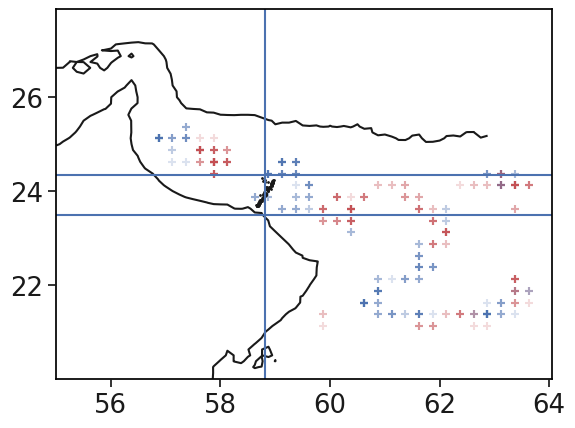

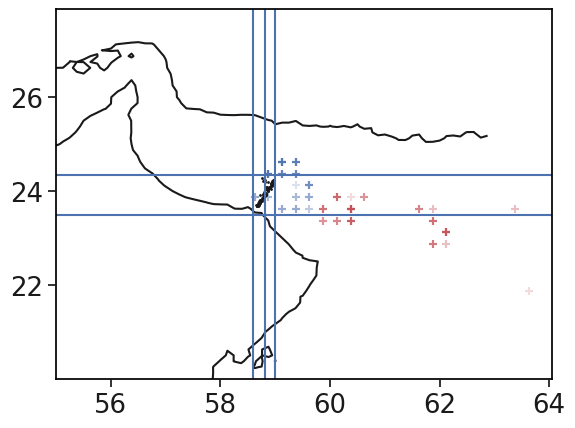

In [14]:
toeddies_atlas=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/TOEddies_altas_2.nc')
ds_79_per_day=ds_79.resample(t='1D').mean().mean('pressure')

plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[0], colors='k')
plt.scatter(toeddies_atlas.center_lon_a.values, toeddies_atlas.center_lat_a.values, marker='+', c='b', alpha=0.2)
plt.scatter(toeddies_atlas.center_lon_c.values, toeddies_atlas.center_lat_c.values, marker='+', c='r',alpha=0.2)
plt.scatter(ds_79_per_day['longitude'], ds_79_per_day['latitude'], s=1, c='k')

plt.axvline(ds_ssh_15_16.isel(longitude=38).longitude.item())
plt.axhline(24.35)
plt.axhline(23.5)
plt.show()

toeddies=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/MW_eddies_SoO_2.nc')

plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[0], colors='k')
plt.scatter(toeddies.center_lon_a.values, toeddies.center_lat_a.values, marker='+', c='b', alpha=0.2)
plt.scatter(toeddies.center_lon_c.values, toeddies.center_lat_c.values, marker='+', c='r',alpha=0.2)
plt.scatter(ds_79_per_day['longitude'], ds_79_per_day['latitude'], s=1, c='k')

plt.axvline(ds_ssh_15_16.isel(longitude=38).longitude.item())
plt.axvline(58.6)
plt.axvline(59)

plt.axhline(24.35)
plt.axhline(23.5)


In [15]:
## COLLOCATE TO GLIDER _ MIN DISTANCE

# toeddies_edge

In [16]:
toeddies_center_lat=toeddies.center_lat_a.interp_like('time'==ds_79.t.rename({'t':'time'}))
toeddies_center_lon=toeddies.center_lon_a.interp_like('time'==ds_79.t.rename({'t':'time'}))
toeddies_edge=toeddies.edge_a.interp_like('time'==ds_79.t.rename({'t':'time'}))

# Get a mask of where edge_a == 1
mask = toeddies_edge == 1

# Get the coordinates (lat, lon) where the condition is met
lat_vals = toeddies_edge['lat'].values
lon_vals = toeddies_edge['lon'].values

# Use .nonzero() or np.argwhere
results = []
for t in tqdm(range(len(toeddies_edge.time))):
    idx = np.argwhere(mask.isel(time=t).values)
    # idx is an array of (lat_index, lon_index)
    coords = [(float(lat_vals[i]), float(lon_vals[j])) for i, j in idx]
    results.append(coords)


def haversine(lat1, lon1, lat2, lon2):
    """
    Compute the great circle distance between two points (in degrees).
    All inputs can be arrays.
    """
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # in kilometers


dis_timestep=[]
dis_max_vel=[]
dis_center_eddy=[]
dis_edge_center=[]
closest_lat_edge=[]
closest_lon_edge=[]
for timsetep in tqdm(range(len(results))):
    # timsetep=85
    # Your list of lat/lon points to check against (shape: N points)
    lat_list = [x[0] for x in results[timsetep]]
    lon_list = [x[1] for x in results[timsetep]]
    
    lat_center = toeddies_center_lat[timsetep].item()
    lon_center = toeddies_center_lon[timsetep].item()
    
    # The target lat/lon (can be single point or arrays)
    target_lat = ds_79.latitude.mean('pressure')[timsetep].item()
    target_lon = ds_79.longitude.mean('pressure')[timsetep].item()
    
    # Compute distance from target to all points
    distances = haversine(target_lat, target_lon, lat_list, lon_list)
    if len(distances)==0:
        closest_distance=np.nan
    else:
        # Get index of minimum distance
        min_idx = np.argmin(distances)
        
        # Get closest point and distance
        closest_lat = lat_list[min_idx]
        closest_lon = lon_list[min_idx]
        closest_distance = distances[min_idx]
    
    distances_radius = haversine(target_lat, target_lon, lat_center, lon_center)
    radius_distance = distances_radius
    
    distances_edge_radius= haversine(closest_lat, closest_lon, lat_center, lon_center)
    edge_radius_distance = distances_edge_radius
    
    if radius_distance<edge_radius_distance:
        # print(edge_radius_distance, radius_distance)
        closest_distance=-closest_distance
    
    closest_distance, radius_distance, edge_radius_distance
    closest_lat_edge.append(closest_lat)
    closest_lon_edge.append(closest_lon)
    dis_timestep.append(closest_distance)
    dis_center_eddy.append(radius_distance)
    dis_edge_center.append(edge_radius_distance)


ds_79['distance_edge_AC']=('t',np.array(dis_timestep).astype(float)) 
ds_79['distance_center_AC']=('t',np.array(dis_center_eddy).astype(float)) 

  0%|          | 0/1423 [00:00<?, ?it/s]

  0%|          | 0/1423 [00:00<?, ?it/s]

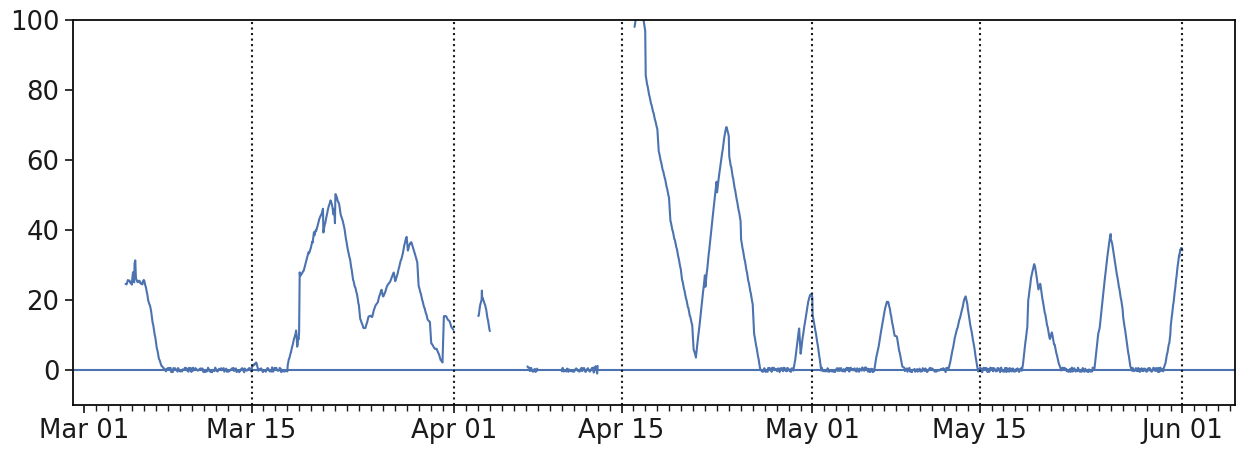

In [17]:
plt.figure(figsize=(15,5))
plt.plot(ds_79.t, ds_79.distance_edge_AC)
plt.ylim(-10,100)
plt.axhline(0)

for i in times_:
    plt.axvline(i, c='k', ls=':')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    # kk.tick_params(axis='both', labelsize=15)

In [18]:
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=2.1)
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable



def plotmap_edd(tid, axis, cmass):
    axis.set_title('(a'+str(cmass)+') '+pd.Timestamp(tid).strftime("%b %d"))
    cb=axis.contourf(ds_ssh_15_16.longitude, ds_ssh_15_16.latitude, ds_ssh_15_16.adt.sel(time=tid, method='nearest'), vmin=.5, vmax=.7, levels=100, cmap=cmo.deep_r)
    # axis.quiver(ds_ssh_15_16.longitude[::3], ds_ssh_15_16.latitude[::3], ds_ssh_15_16.ugos.sel(time=tid, method='nearest')[::3, ::3], ds_ssh_15_16.vgos.sel(time=tid, method='nearest')[::3, ::3], scale=5)
    axis.plot([58.63,59.03],[23.65, 24.28], lw=3, c='k')

    axis.scatter(ds_79.sel(t=tid, method='nearest').lon_pp, ds_79.sel(t=tid, method='nearest').lat_pp, c='yellow', marker="d", s=100, edgecolor='k', zorder=100)
    axis.contour(df_bath.lon[::10], df_bath.lat[::10], df_bath.elevation[::10, ::10], levels=[0], colors='k')
    axis.contourf(df_bath.lon[::10], df_bath.lat[::10], df_bath.elevation[::10, ::10], levels=[0, 3000], colors='w')
    
    # axis.set_xlabel('Longitude ($^{o}$E)')
    axis.set_ylim(22,26)
    axis.set_xlim(56,62)
    axis.set_xticks([57,59,61], labels=['57$^{o}$','','61$^{o}$'])
    axis.set_yticks([22,24,26], labels=['22$^{o}$','24$^{o}$','26$^{o}$'])

    # plt.ylim(22,26)
    # plt.xlim(56,63)

    toeddies_plt=toeddies_atlas.copy()
    # axis.set_xticks([56, 58, 60, 62])
    axis.contour(toeddies_plt.lon, toeddies_plt.lat, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').sum('anticyclone_id').edge_a, levels=[0, 1], colors='red', linewidths=2)#-ds_eddies_c.sum('eddy_id').mask)
    # axis.contour(toeddies_plt.lon, toeddies_plt.lat, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').sum('anticyclone_id').max_speed_a, levels=[0, 1], colors='pink')#-ds_eddies_c.sum('eddy_id').mask)
    axis.scatter(toeddies_plt.sel(time=pd.Timestamp(tid)).center_lon_a, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').center_lat_a, marker='x', c='red', s=100, linewidths=3)
    axis.contour(toeddies_plt.lon, toeddies_plt.lat, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').sum('cyclone_id').edge_c, levels=[0, 1], colors='blue', linewidths=2)#-ds_eddies_c.sum('eddy_id').mask)
    # axis.contour(toeddies_plt.lon, toeddies_plt.lat, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').sum('cyclone_id').max_speed_c, levels=[0, 1], colors='cyan')#-ds_eddies_c.sum('eddy_id').mask)
    axis.scatter(toeddies_plt.sel(time=pd.Timestamp(tid)).center_lon_c, toeddies_plt.sel(time=pd.Timestamp(tid), method='nearest').center_lat_c, marker='x', c='blue', s=100, linewidths=3)
    return cb

times_=[ds_ssh_15_16.sel(time='2015-03-15').adt.time.values,ds_ssh_15_16.sel(time='2015-04-01').adt.time.values,  ds_ssh_15_16.sel(time='2015-04-15').adt.time.values, ds_ssh_15_16.sel(time='2015-05-01').adt.time.values, ds_ssh_15_16.sel(time='2015-05-15').adt.time.values, ds_ssh_15_16.sel(time='2015-06-01').adt.time.values]


## PLOT FIGURE 4

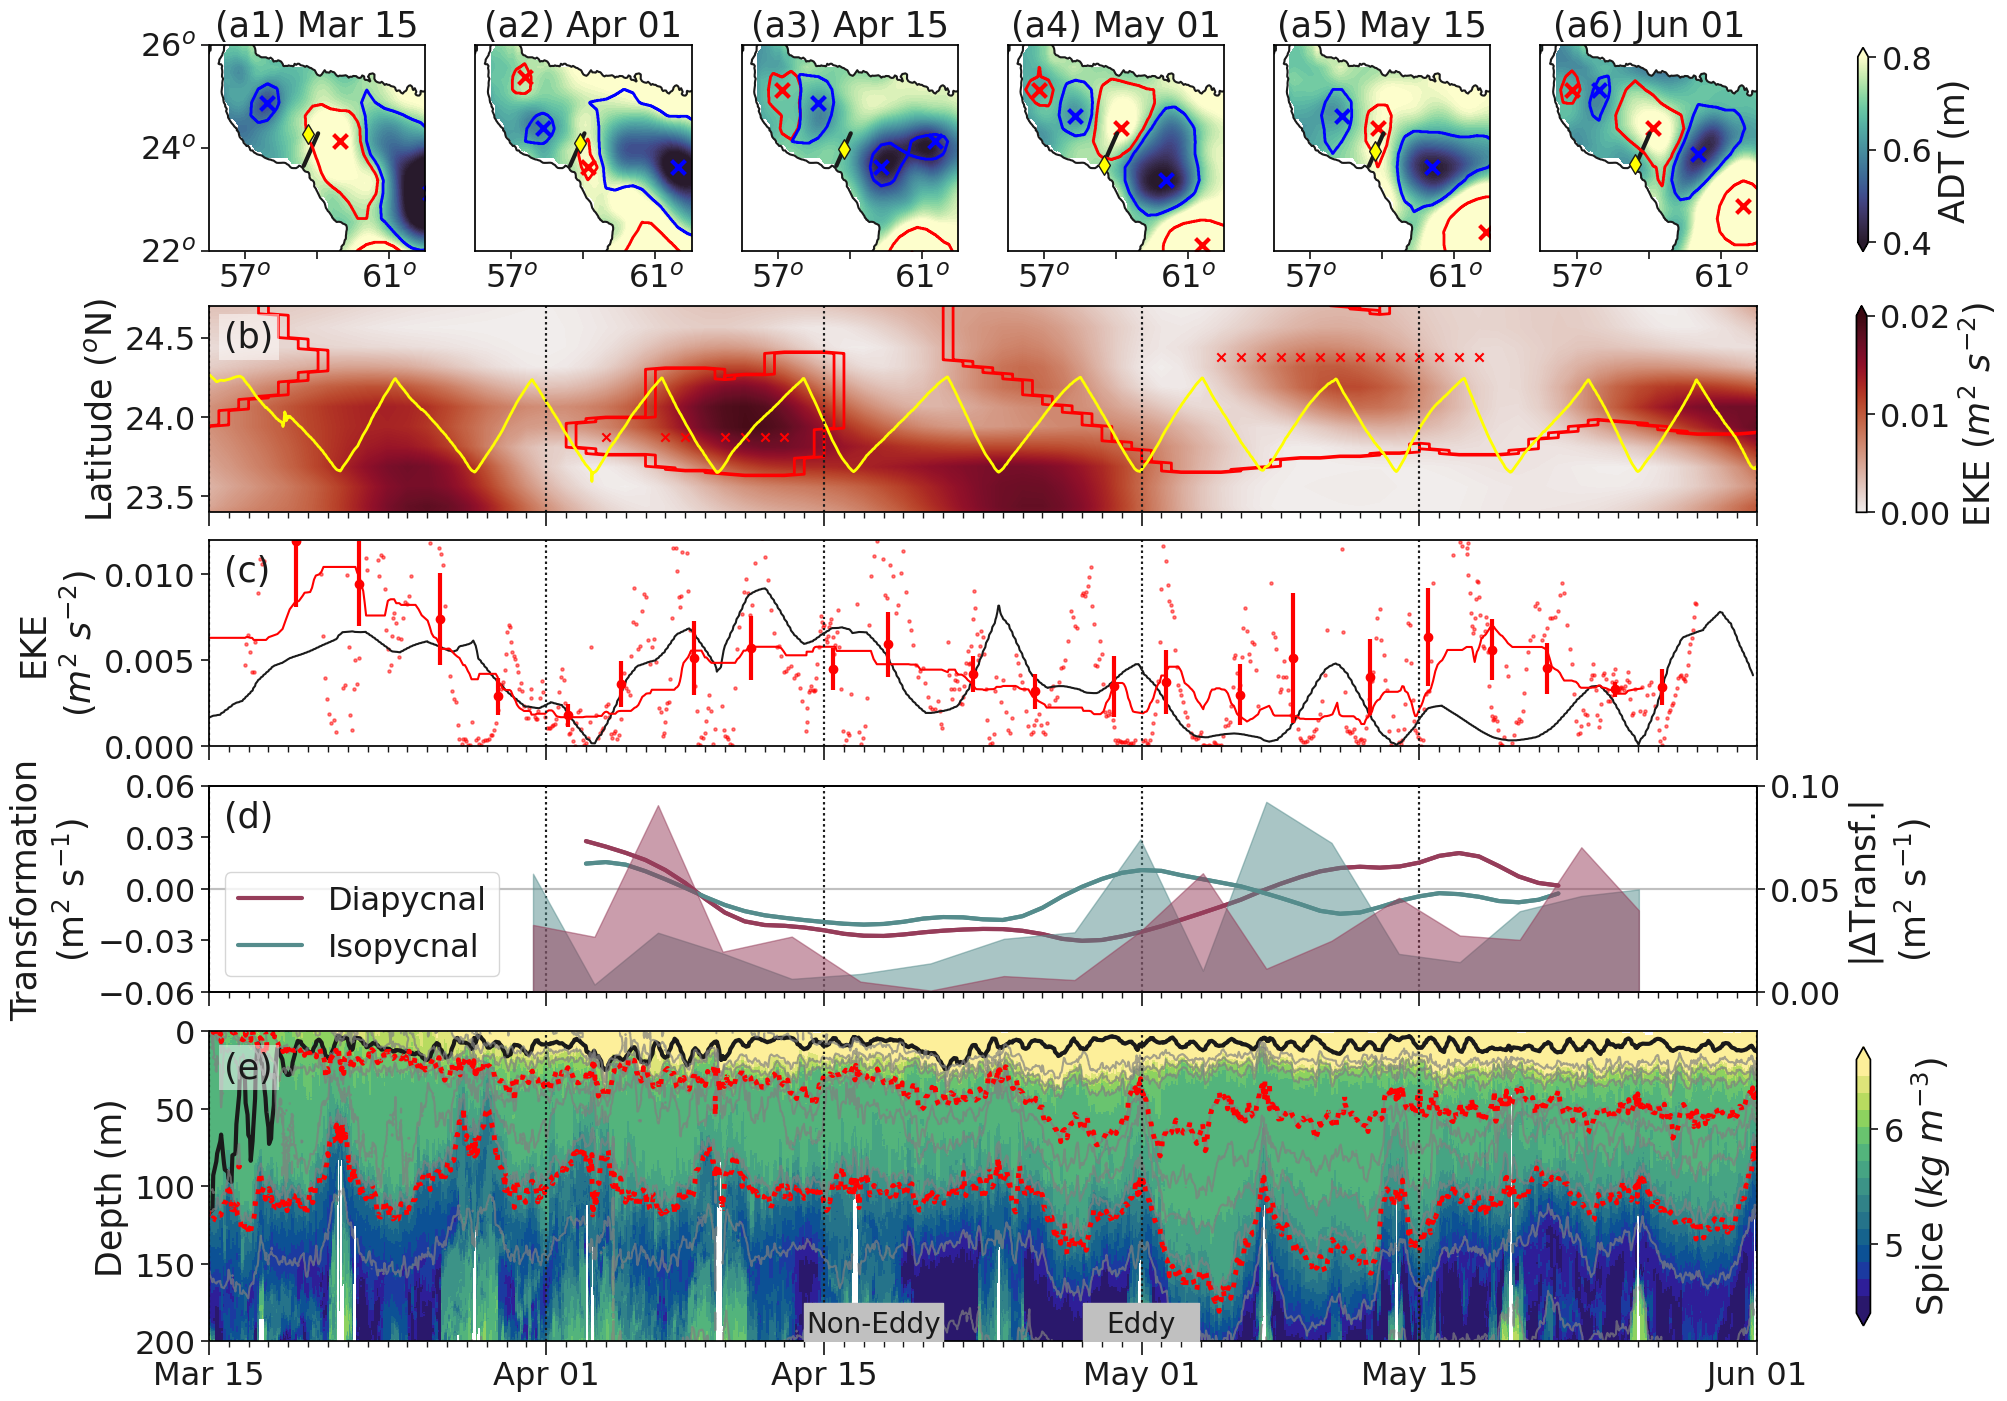

In [24]:
sigmamin_, sigmamax_ = 25, 25.25
spicemin_, spicemax_ =4.7,6.3


fig=plt.figure(figsize=(20,17), constrained_layout=True)
# fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(15-1,6, figure=fig)

ax01 = fig.add_subplot(gs[:2,0])
ax02 = fig.add_subplot(gs[:2,1])
ax03 = fig.add_subplot(gs[:2,2])
ax04 = fig.add_subplot(gs[:2,3])
ax05 = fig.add_subplot(gs[:2,4])
ax06 = fig.add_subplot(gs[:2,5])

ax3 = fig.add_subplot(gs[2:4,:])

ax3_3 = fig.add_subplot(gs[4:6,:])
# ax3_33 = fig.add_subplot(gs[5:7,:])

ax22_ = fig.add_subplot(gs[6:8,:])

NN=8

ax4 = fig.add_subplot(gs[NN:NN+3,:])
# ax5 = fig.add_subplot(gs[NN+3:NN+6,:])
# ax6 = fig.add_subplot(gs[NN+4:NN+6,:])
# ax7 = fig.add_subplot(gs[NN+6:,:])

cbbb_adt=plotmap_edd(times_[0], ax01, 1)
# ax01.set_ylabel('Latitude ($^{o}$N)')
plotmap_edd(times_[1], ax02, 2)
ax02.set_yticks([])
plotmap_edd(times_[2], ax03, 3)
ax03.set_yticks([])
plotmap_edd(times_[3], ax04, 4)
ax04.set_yticks([])
plotmap_edd(times_[4], ax05, 5)
ax05.set_yticks([])
plotmap_edd(times_[5], ax06, 6)
ax06.set_yticks([])


#####

ax3_3.plot(eke_sat.time, 0.5*eke_sat.sel(latitude=ds_79.lat_pp.rename({'t':'time'}), method='nearest').rolling(time=24, center=True).mean(), c='k')
ax3_3.scatter(pd.to_datetime(np.concatenate(time_)), np.concatenate(np.array((DAC_u_prime**2+DAC_v_prime**2))), s=5, c='red', alpha=0.5)
ax3_3.plot(pd.to_datetime(np.concatenate(time_))[~np.isnan(pd.to_datetime(np.concatenate(time_)))].sort_values(),
         pd.DataFrame(np.concatenate(np.array((DAC_u_prime**2+DAC_v_prime**2)))[~np.isnan(pd.to_datetime(np.concatenate(time_)))]).rolling(72, center=True).median(), c='red')

ax3_3.set_ylabel('EKE\n($m^2$ $s^{-2}$)')
ax3_3.set_ylim(0,0.012)
ax3_3.errorbar(pd.to_datetime(ds2_.time.mean('pressure').mean('profile_number').values), np.nanmean(np.array((DAC_u_prime**2+DAC_v_prime**2)), axis=1), yerr=np.nanstd(np.array((DAC_u_prime**2+DAC_v_prime**2)/2),  axis=1), lw=3, fmt='o', c='red')


# ####
# ax3.plot(ds_79.t, ds_79.distance.mean('pressure'), c='k')
bbb=ax3.pcolormesh(ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).time, 
               ds_ssh_15_16.latitude, 0.5*(uprime**2+vprime**2).T, vmin=0, vmax=0.02, cmap=cmo.amp, zorder=-100)
plt.colorbar(bbb, label='EKE ($m^2$ $s^{-2}$)', extend='max',  pad=-0.05)

bbb=ax3.contourf(ds_ssh_15_16.sel(time=slice(pd.to_datetime('2015-03-01'), pd.to_datetime('2015-06-01'))).time, 
               ds_ssh_15_16.latitude, 0.5*(uprime**2+vprime**2).T,levels=1000, vmin=0, vmax=0.02, cmap=cmo.amp, zorder=-99)
# plt.colorbar(bbb, label='EKE ($m^2$ $s^{-2}$)', extend='max',  pad=-0.05)
ax3.set_ylim(23.4,24.7)
# plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))

# ax3.contour(toeddies.time, toeddies.lat, toeddies.sel(lon=slice(58.6, 59)).edge_a.median('lon').T, levels=1, colors='red', linewidths=2)
# ax3.contour(toeddies.time, toeddies.lat, toeddies.sel(lon=slice(58.6, 59)).max_speed_a.median('lon').T, levels=1, colors='pink')
eds_=toeddies.sel(lon=slice(58.6, 59)).edge_a.median('lon')
eds_=eds_.where(eds_==1, np.nan).ffill('time', limit=2)
eds_=eds_.where(eds_==1, 0)
ax3.contour(toeddies.time, toeddies.lat, eds_.T, levels=1, colors='red', linewidths=2)


msk= (toeddies.center_lon_a<59) & (toeddies.center_lon_a>58.6)
ax3.scatter(toeddies.time[msk], toeddies.center_lat_a[msk], marker='x', c='red')


ax3.plot(ds_79.t, ds_79.lat_pp, c='yellow', linewidth=2)
ax3.set_ylabel('Latitude ($^{o}$N)')

# delta_=24.7-23.4
# ax3.fill_betweenx([24.7-delta_*10/100,24.7], pd.to_datetime('2015-04-14'), pd.to_datetime('2015-04-21'), alpha=1, color='b', zorder=100)
# ax3.fill_betweenx([24.7-delta_*10/100,24.7], pd.to_datetime('2015-04-28 01:30:00'), pd.to_datetime('2015-05-03 22:00:00'), alpha=1, color='orange', zorder=100)



################



# sigmin_t, sigmaxt=24.975, 25.045
sigmin_t, sigmaxt= 25.075, 25.125
sigmin_, sigmax=25, 25.25
sigmin_b, sigmaxb=25.225, 25.285


sm, SM=sigmin_, sigmax
# print(sm, SM)
ax22_.axhline(0, c='silver')
ax22_.plot([0,0], [1,1], lw=3, c=c_diapy, label='Diapycnal')
ax22_.plot([0,0], [1,1], lw=3, c=c_isopyc, label='Isopycnal')
ax22_.legend(ncol=1, loc='lower left')#, bbox_to_anchor=(1, 0.5))
# ax3 = ff.add_subplot(spec2[2:, 4:])
ax22_.set_ylim(-0.06, 0.06)
ax22_.set_yticks([-0.06, -0.03, 0, 0.03, 0.06])
ax22_.axhline(0, c='silver', zorder=-10)
isopt=glider_trans.G_si.sel(T_bini=slice(sm, SM)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])
diapt=glider_trans.G_ti.sel(T_bini=slice(sm, SM)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])
ax22_.set_ylabel('Transformation\n(m$^{2}$ s$^{-1}$)')  
new_time = pd.date_range(start=pd.to_datetime('2015-03-15'), 
                             end=pd.to_datetime('2015-07-01'), 
                             freq='1D')  # Hourly frequency
G_si_interp = isopt.interp(time_mid=new_time)
G_ti_interp = diapt.interp(time_mid=new_time)
# ep_interp = ep.interp(time_mid=new_time)

ax22_.plot(G_ti_interp.time_mid, G_ti_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_diapy, label='Diapycnal Transf.', zorder=1000)
ax22_.plot(G_si_interp.time_mid, G_si_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_isopyc, label='Isopycnal Transf.',  zorder=1000)
# plt.plot(G_si_interp.time_mid, ep_interp.rolling(time_mid=10, center=True).mean(), lw=3, c='red', label='exch.')

ax22_2=ax22_.twinx()
# plt.plot(glider_trans.time_mid[1:], np.abs(np.diff(isopt)), c=c_isopyc, alpha=0.5)
# plt.plot(glider_trans.time_mid[1:], np.abs(np.diff(diapt)), c=c_diapy, alpha=0.5)
ax22_2.fill_between(glider_trans.time_mid[1:], np.abs(np.diff(isopt))*0, np.abs(np.diff(isopt)), color=c_isopyc, alpha=0.5, zorder=-100)
ax22_2.fill_between(glider_trans.time_mid[1:], np.abs(np.diff(diapt))*0, np.abs(np.diff(diapt)), color=c_diapy, alpha=0.5)
ax22_2.set_ylabel(' |$\Delta$Transf.|\n(m$^{2}$ s$^{-1}$)')  
ax22_2.set_yticks([0,0.05, 0.1])
ax22_2.set_ylim(0, 0.1)
# ax22_.set_xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))
# ax22_.set_ticks([pd.to_datetime('2015-03-15'), pd.to_datetime('2015-04-01'), pd.to_datetime('2015-04-15'), pd.to_datetime('2015-05-01'), pd.to_datetime('2015-05-15'), pd.to_datetime('2015-06-01')])             
ax22_.plot(G_ti_interp.time_mid, G_ti_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_diapy, label='Diapycnal Transf.', zorder=1000)
ax22_.plot(G_si_interp.time_mid, G_si_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_isopyc, label='Isopycnal Transf.',  zorder=1000)


# ax22_2.fill_betweenx([0.09,0.1], pd.to_datetime('2015-04-14'), pd.to_datetime('2015-04-21'), alpha=1, color='b', zorder=-100)
# ax22_2.fill_betweenx([0.09,0.1], pd.to_datetime('2015-04-24'), pd.to_datetime('2015-05-01'), alpha=1, color='orange', zorder=-100)



##########################


cmap_spice=plt.get_cmap('cmo.haline', 15)
cb=ax4.pcolormesh(ds_79.t, ds_79.pressure, ds_79.spice, vmin=spicemin_-0.3, vmax=spicemax_+0.3, cmap=cmap_spice)
ax4.plot(ds_79.t, ds_79.mixed_layer_depth.ffill('t').rolling(t=5, center=True).mean(), c='k', lw=3)
# plt.plot(ds_grid.time, ds_grid.mixed_layer_depth.rolling(time=5, center=True).mean(), lw=3, c='k')

ax4.contour(ds_79.t, ds_79.pressure, ds_79.potential_density, levels=[24,24.5, 24.75, 25, 25.05, 25.1 , 25.2, 25.5,26, 26.5, 27], colors='gray', alpha=0.7)
ax4.contour(ds_79.t, ds_79.pressure, ds_79.potential_density, levels=[sigmamin_, sigmamax_], linestyles=[':', ':'], colors='red', linewidths=[3.5,3.5])

ax4.set_ylim(200,0)
ax4.set_xlim(ds_79.t.min(), ds_79.t.max())
ax4.set_xlim(pd.to_datetime('2015-03-10'), pd.to_datetime('2015-06-01'))

cb=plt.colorbar(cb, extend='both', pad=-0.05, shrink=0.9)
cb.set_label('Spice ($kg$ $m^{-3}$)')
ax4.set_xticks([])
ax4.set_ylabel('Depth (m)')

# deltasigm=np.abs(+0.15-(sigmamin_-0.15))
# ax4.fill_betweenx([187,200], pd.to_datetime('2015-04-14'), pd.to_datetime('2015-04-21'), alpha=1, color='silver', zorder=100)
# ax4.fill_betweenx([187,200],pd.to_datetime('2015-04-28 01:30:00'), pd.to_datetime('2015-05-03 22:00:00'), alpha=1, color='silver', zorder=100)

ymin, ymax = 175, 200

# CASE 1
start1 = pd.to_datetime('2015-04-14')
end1   = pd.to_datetime('2015-04-21')
ax4.fill_betweenx([ymin, ymax], start1, end1, alpha=1, color='silver', zorder=100)
ax4.text(start1 + (end1 - start1) / 2, ymax - 20, 'Non-Eddy',
         ha='center', va='top', fontsize=20, zorder=101)

# CASE 2
start2 = pd.to_datetime('2015-04-28 01:30:00')
end2   = pd.to_datetime('2015-05-03 22:00:00')
ax4.fill_betweenx([ymin, ymax], start2, end2, alpha=1, color='silver', zorder=100)
ax4.text(start2 + (end2 - start2) / 2, ymax - 20, 'Eddy',
         ha='center', va='top', fontsize=20, zorder=101)


for kk in [ax3_3, ax22_, ax3, ax4]:
    for i in times_:
        kk.axvline(i, c='k', ls=':')
        
    kk.set_xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))


# for kk in [ax3_3, ax22_, ax3, ax4]:
#     for i in [pd.to_datetime('2015-04-14'), pd.to_datetime('2015-04-21')]:
#         kk.axvline(i, c='b',alpha=0.5, lw=2)

# for kk in [ax3_3, ax22_, ax3, ax4]:
#     for i in [pd.to_datetime('2015-04-28 01:30:00'), pd.to_datetime('2015-05-03 22:00:00')]:
#         kk.axvline(i, c='orange',alpha=0.5, lw=2)
        
letterss=['(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for ind, kk in enumerate([ax3_3, ax22_, ax3, ax4]):  
    # kk.set_xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-06-01'))
    kk.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    kk.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    # kk.tick_params(axis='both', labelsize=15)
    kk.tick_params(axis='x', length=10)  # Default is usually ~3.5

    for i in times_:
        kk.axvline(i, c='k', ls=':')
ax4.set_xticks([pd.to_datetime('2015-03-15'), pd.to_datetime('2015-04-01'), pd.to_datetime('2015-04-15'), pd.to_datetime('2015-05-01'), pd.to_datetime('2015-05-15'), pd.to_datetime('2015-06-01')])        
for ax in [ax3_3, ax3,ax22_]:#, ax3, ax4]:
    ax.xaxis.set_ticklabels([])
# fntsize=20
ax3.text(0.01, 0.8, letterss[0], transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

for ind, kk in enumerate([ax3_3, ax22_]):  
    kk.text(0.01, 0.8, letterss[ind+1], transform=kk.transAxes)

for ind, kk in enumerate([ax4]):  
    kk.text(0.01, 0.85, '(e)', transform=kk.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))


norm = Normalize(vmin=0.4, vmax=0.8)
fake_mappable = ScalarMappable(norm=norm, cmap='cmo.deep_r')
cbar_ax = fig.add_axes([0.926, 0.855, 0.0052, 0.12])  # Right side of plot
fig.colorbar(fake_mappable, cax=cbar_ax, ticks=[0.4, 0.6,0.8], label='ADT (m)', extend='both')


plt.savefig('Fig4.png', dpi=600)